# This Notebook Explores Computer Vision Using MNIST Dataset.

In [2]:
# Required libraries are loaded. 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier

In [3]:
# Files to be used.
path = "../../../Data/digit-recognizer/"
train = pd.read_csv(path + "train.csv")
test = pd.read_csv(path + "test.csv")

In [4]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


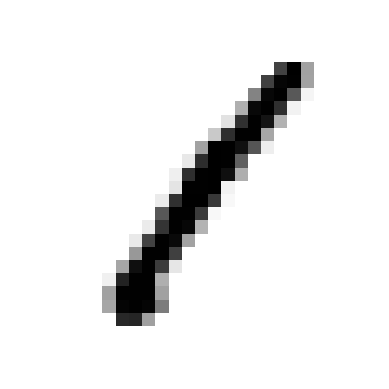

In [6]:
# Here we are visualizing a sample observation.
obs = train.iloc[0,][1:].to_numpy()
im = obs.reshape(28, 28)
plt.imshow(im, cmap="binary")
plt.axis("off")
plt.show()

In [7]:
X_train = train.loc[:,"pixel0":].to_numpy()
y_train = train.loc[:,"label"].to_numpy()
test = test.to_numpy()

# Currently no data preparation therefore jumping to building a model.

### Let's build many models then choose the most promising to hypetune.

After building sgd, naive bayes, random forest and kneighbors, the latter two are the most promising.
Random Forest is taking forever to train so will just work with kneighbors.

The best kneighbors parameters to use are n_neighbors=4 and weights=distance

In [11]:
# These models natively handle multiclass classification.
knn_clf = KNeighborsClassifier()

In [12]:
# Parameters for tuning the models.
params_knn = [{"weights": ["distance"], "n_neighbors": [4, 10, 12]}]

In [13]:
# Use grid search to search the hyperparameter space.
grid_search = GridSearchCV(knn_clf, params_knn, scoring="accuracy", cv=5, verbose=3)

In [14]:
# Fit the grid search to search the hyperparamter space.
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END ...n_neighbors=4, weights=distance;, score=0.971 total time=   9.9s
[CV 2/5] END ...n_neighbors=4, weights=distance;, score=0.969 total time=   9.0s
[CV 3/5] END ...n_neighbors=4, weights=distance;, score=0.966 total time=  10.0s
[CV 4/5] END ...n_neighbors=4, weights=distance;, score=0.967 total time=   9.7s
[CV 5/5] END ...n_neighbors=4, weights=distance;, score=0.972 total time=  12.4s
[CV 1/5] END ..n_neighbors=10, weights=distance;, score=0.966 total time=  19.7s
[CV 2/5] END ..n_neighbors=10, weights=distance;, score=0.966 total time=  19.1s
[CV 3/5] END ..n_neighbors=10, weights=distance;, score=0.961 total time=  21.3s
[CV 4/5] END ..n_neighbors=10, weights=distance;, score=0.963 total time=  15.7s
[CV 5/5] END ..n_neighbors=10, weights=distance;, score=0.969 total time=  10.9s
[CV 1/5] END ..n_neighbors=12, weights=distance;, score=0.964 total time=   8.5s
[CV 2/5] END ..n_neighbors=12, weights=distance;,

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': [4, 10, 12], 'weights': ['distance']}],
             scoring='accuracy', verbose=3)

In [15]:
# See how the models performed in the various parameters.
cvres_knn = grid_search.cv_results_

In [16]:
for mean_test_score, params in zip(cvres_knn["mean_test_score"], cvres_knn["params"]):
    print(f"mean_test_score is: {mean_test_score*100:.2f} and params: {params}")

mean_test_score is: 96.91 and params: {'n_neighbors': 4, 'weights': 'distance'}
mean_test_score is: 96.48 and params: {'n_neighbors': 10, 'weights': 'distance'}
mean_test_score is: 96.35 and params: {'n_neighbors': 12, 'weights': 'distance'}


In [17]:
knn_pred = grid_search.predict(test)

In [18]:
df = pd.DataFrame()
df["ImageId"] = np.arange(1, 28001)
df["Label"] = knn_pred
df.to_csv("kneigbors.csv", index=False)

### Data Augmentation

In [38]:
from scipy.ndimage import shift

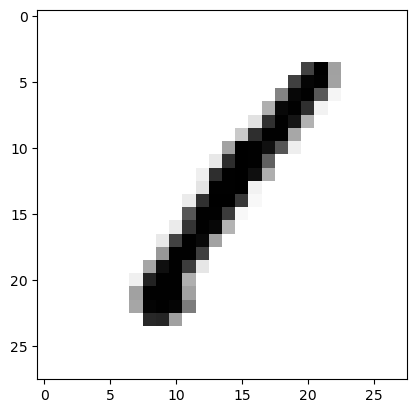

In [60]:
some_digit = X_train[0]
some_digit = some_digit.reshape(28, 28)
plt.imshow(some_digit, cmap="binary")
plt.show()

In [64]:
some_digit_shifted = shift(some_digit, [2], cval=0)
plt.imshow(some_digit_shifted, cmap="binary")
plt.show()

RuntimeError: sequence argument must have length equal to input rank